# CI data analysis: availability sequences first exploration

The latest file for creating availability matrices is ``CI_analysis_availability_matrices_2.ipynb``.

In [1]:
# Import libraries:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import *
import math

**Set values for countries and dates:**

In [2]:
# Dates:
n_rounds = 100

# countries to study:
countries = ['Ireland', 'Germany', 'Great Britain', 'France', 'Sweden', 'Finland', 'Belgium']
list_colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'yellow']
# countries = ['Ireland', 'Germany', 'Great Britain']
# list_colors = ['red', 'green', 'blue']

**Definition of variables and useful functions:**

In [3]:
folder = 'figures/av-mat-1'

# Start and end dates:
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=n_rounds-1)

# data preparation:
_dfs = load_data()
datetime_values = get_datetime_values(_dfs, countries[0], start_date, end_date)

# initialize the similarity matrix:
time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [dt.strftime("%d %h, %H:%M") for dt in time_values]
formatted_array = [i for i in range(n_rounds)]

# functions:
def create_availability_seq(CI_seq, decision, threshold=0):
    """
    Creates an array of booleans.
    Each value corresponds to one hour.
    It is True is the node is available during this hour, and False otherwise.
    """

    if decision == 'local_mean':
        threshold = CI_seq.mean()

    if decision == 'local_median':
        threshold = np.median(CI_seq)
    
    availability_seq=CI_seq <= threshold

    return(availability_seq.astype(int))

def save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix):
    dict_cols = dict(zip(formatted_array, datetime_values)) # get the datetime values
    availability_matrix_to_save = availability_matrix.rename(columns=dict_cols)
    availability_matrix_to_save.to_csv('availability_matrices/av-mat-1/availability_matrix_'+key_word+'.csv', columns=datetime_values)

**Raw data:**

Let us display the raw data in between the chosen dates.

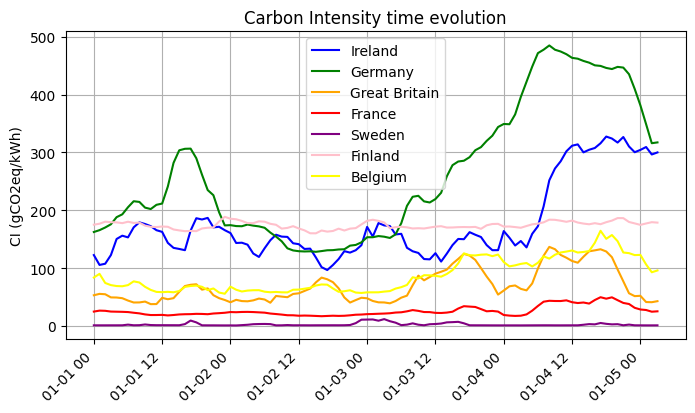

In [4]:
fig = plt.figure(figsize=(8, 4))

for country_idx, country in enumerate(countries):

    df_country = _dfs[country]
    df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

    # plot:
    plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])

    # plot legend, axis, etc.:
    # ax.set_xlim([df_to_plot['datetime'].values[0], df_to_plot['datetime'].values[-1]])
    plt.title('Carbon Intensity time evolution')
    plt.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    _ = plt.xticks(rotation=90)  
    plt.grid()
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    plt.ylabel('CI (gCO2eq/kWh)')
# plt.savefig(os.path.join('figures/raw_CI_data.png'), bbox_inches='tight')
plt.show()

Lets compute the mean value for each country in between these two dates, and the global mean over all countries.

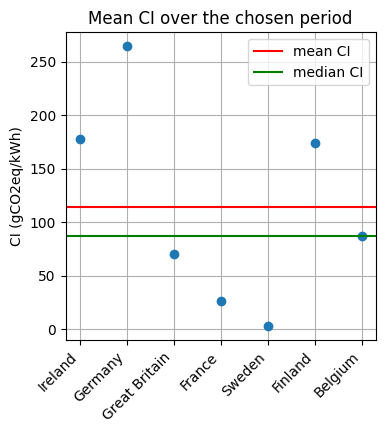

In [5]:
mean_list=[]
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    mean_list.append(CI_values.mean())
dict_countries_CI = dict(zip(countries, mean_list))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plt.plot(countries, mean_list, 'o')
plt.title('Mean CI over the chosen period')
plt.ylabel('CI (gCO2eq/kWh)')
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
plt.grid()

global_mean_CI = np.array(mean_list).mean()
ax.axhline(y=global_mean_CI, color='r', linestyle='-', label='mean CI')

median_CI = np.median(np.array(mean_list))
ax.axhline(y=median_CI, color='g', linestyle='-', label='median CI')

ax.legend()

# plt.savefig('figures/means.png', bbox_inches='tight')

plt.show()

**Carbon Intensity matrix:** contains CI values in gCO2eq/kWh

In [6]:
# initialize the similarity matrix:
# time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [i for i in range(len(time_values))]
CI_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    CI_matrix.loc[country, :] = CI_values

## Availability with a threshold specific to each country

We may expect this if we **need to use all** computing nodes. For instance, this may be the case when the data in the different computing nodes is not the same and it is important to use all of it.

### Using the country mean as threshold

Below we are going to chose these means as threshold for each country. This permits to ensure that all computing nodes are available during some time intervalls.

**Here, we can also save the availability matrix that will be used for the FL training.**

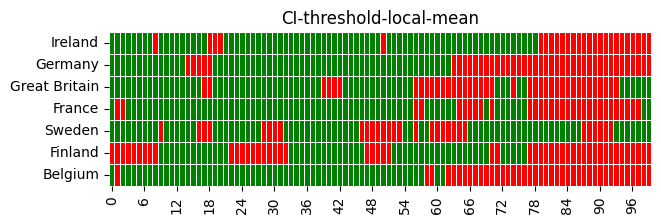

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Ireland,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Germany,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Great Britain,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,1,1,1
France,1,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
Sweden,1,1,1,1,1,1,1,1,1,0,...,0,0,0,1,1,1,1,1,1,1
Finland,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Belgium,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
key_word = 'CI-threshold-local-mean'

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    availability_seq = create_availability_seq(CI_values, 'local_mean')
    availability_matrix.loc[country, :] = availability_seq


plot_availability_heatmap("", availability_matrix, key_word, folder=folder)
display(availability_matrix)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

**Check the mean value over columns:**

In [8]:
# df = pd.DataFrame(pd.read_csv("availability_matrices/availability_matrix_local_mean.csv", index_col=[0]))
# print(dict(enumerate(df.mean(axis=1))))
# print(dict(enumerate(df.iloc[:, :100].to_numpy().mean(axis=1))))
# print(df.iloc[:, :100].to_numpy().mean(axis=1))

### Using less than the country mean as threshold for countries with largest CI

However, we could also chose to modify these threshold so that each computing node is available at least a certain amount of time.
This would be especilly interesting for the nodes with the highest mean CI.

Total, number of hours:  100 VS Chosen number of hours:  10


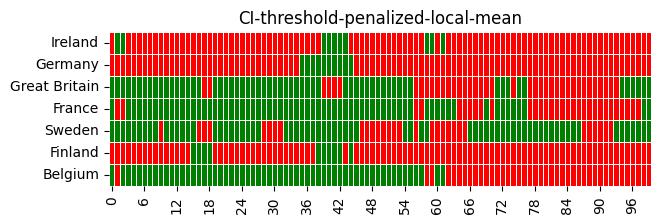

In [9]:
key_word = 'CI-threshold-penalized-local-mean'


countries_threshold = global_mean_CI
# perc_available = 1/4 # used for experiments 05/06/2024
perc_available = 0.1

total_nb_hours=len(get_CI_values(_dfs, countries[0], start_date, end_date))
nb_hours = math.ceil(perc_available*total_nb_hours)
print("Total, number of hours: ", str(total_nb_hours), 'VS Chosen number of hours: ', str(nb_hours))

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    mean_CI = dict_countries_CI[country]
    CI_values = np.array(get_CI_values(_dfs, country, start_date, end_date))
    if mean_CI > countries_threshold:
        global_threshold = max(CI_values[CI_values.argsort()[:nb_hours]])
        availability_seq = create_availability_seq(CI_values, 'global_threshold', global_threshold)
    else:
        availability_seq = create_availability_seq(CI_values, 'local_mean')
    availability_matrix.loc[country, :] = availability_seq

plot_availability_heatmap("", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

### Uniform carbon budget 

Each country has the same carbon budget

We suppose that the power draw for all clients is constant and equal. At the moment we take the constant 200 Watts.

The formula for carbon footprint is: power (W) * duration (hour) * carbon intensity (gCO2/kWh) * 1000

**GHG matrix:** values are the carbon fooprint of sustaining a certain power during ``round_duration`` hours

In [10]:
power = 300/1000 # in kiloWatts
round_duration = 1 # in hours: this is duration of a FL training round
GHG_matrix = CI_matrix * power * round_duration / 1000

display(GHG_matrix)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Ireland,0.036822,0.031704,0.032331,0.036828,0.045159,0.046866,0.045984,0.051192,0.053775,0.052917,...,0.09825,0.097224,0.095139,0.098019,0.093114,0.090135,0.091335,0.092829,0.088965,0.09003
Germany,0.048777,0.049734,0.051111,0.052779,0.056466,0.057936,0.061614,0.064728,0.064368,0.061407,...,0.133821,0.133248,0.13437,0.134004,0.130572,0.122937,0.114441,0.104691,0.094806,0.095223
Great Britain,0.015993,0.016704,0.016506,0.01488,0.014817,0.01446,0.013239,0.012234,0.01227,0.012711,...,0.038682,0.035724,0.029358,0.023211,0.017013,0.015534,0.015702,0.012474,0.012387,0.012921
France,0.007527,0.008019,0.00792,0.007533,0.007464,0.007395,0.007275,0.006918,0.006597,0.006057,...,0.014211,0.01491,0.013431,0.012003,0.011457,0.00948,0.00861,0.008343,0.007464,0.007662
Sweden,0.000402,0.000399,0.000399,0.000408,0.000408,0.000417,0.000762,0.000432,0.000474,0.000837,...,0.001176,0.000903,0.000993,0.000426,0.00078,0.000414,0.000393,0.000378,0.000378,0.00039
Finland,0.052563,0.053067,0.054123,0.053868,0.053766,0.053364,0.054099,0.053484,0.053622,0.05208,...,0.053865,0.054684,0.055992,0.055962,0.053973,0.053238,0.05247,0.053199,0.053868,0.05364
Belgium,0.025179,0.027084,0.02235,0.021243,0.020766,0.020646,0.02124,0.023199,0.022596,0.020358,...,0.045243,0.047205,0.044019,0.038151,0.037812,0.03681,0.036915,0.031968,0.0279,0.028848


Let us now create the availability matrix.

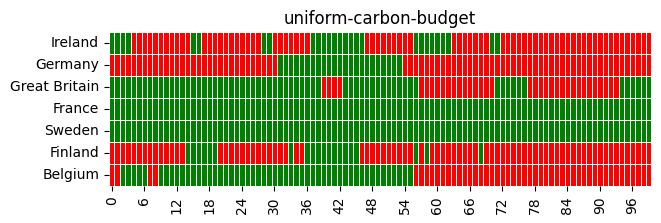

In [11]:
def availability_from_budget(GHG_values, budget):
    sorted_idx = np.argsort(GHG_values)

    sorted_GHG_values = GHG_values[sorted_idx]

    sorted_GHG_cumsum = np.cumsum(sorted_GHG_values)

    selected_idx = sorted_idx[sorted_GHG_cumsum <= budget]

    availability_seq = np.zeros(len(GHG_values), dtype = np.int8)
    availability_seq[selected_idx] = 1
    availability_seq = np.array(availability_seq, dtype=bool)
    return availability_seq

key_word = 'uniform-carbon-budget'

carbon_budget = 1 # in kgCO2eq

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    GHG_values = GHG_matrix.loc[country, :].to_numpy()
    GHG_values = np.array([np.round(x, 4) for x in GHG_values])

    availability_seq = availability_from_budget(GHG_values, carbon_budget)
  
    # print(GHG_values[availability_seq].sum())

    availability_matrix.loc[country, :] = availability_seq

plot_availability_heatmap("", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

### Uniform carbon budget and fine-tuning

Each country has the same carbon budget

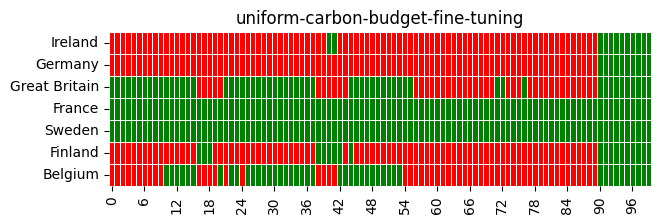

In [12]:
# last 10% of the time is green (available)
# decrease each country carbon budget
# for each country, if some carbon budget is left, then allocate it
key_word = 'uniform-carbon-budget-fine-tuning'

carbon_budget = 1 # in kgCO2eq
percentage_fine_tuning = 0.1

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    GHG_values = GHG_matrix.loc[country, :].to_numpy()
    idx = int(percentage_fine_tuning*len(GHG_values))

    GHG_country = sum(GHG_values[-idx:])
    remaining_budget = carbon_budget - GHG_country

    availability_seq = availability_from_budget(GHG_values, remaining_budget)
    availability_seq[-idx:] = 1

    availability_matrix.loc[country, :] = availability_seq

plot_availability_heatmap("", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

### Using the country median as threshold

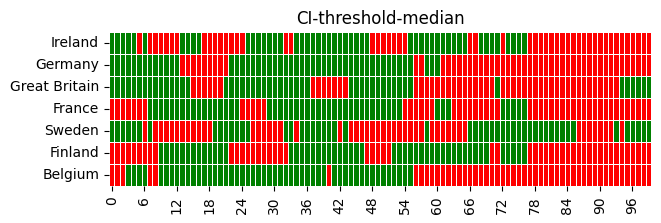

In [13]:
key_word = 'CI-threshold-median'

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    availability_seq = create_availability_seq(CI_values, 'local_median')
    availability_matrix.loc[country, :] = availability_seq

plot_availability_heatmap("", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

## Availability with a global threshold for all countries

We may expect this if we **don't need to use all** of the computing nodes. For instance, it is the case when all the computing nodes have the same data.

[177.5298, 264.44800000000004, 69.8946, 26.144099999999998, 2.7791, 174.38000000000008, 87.33399999999997]


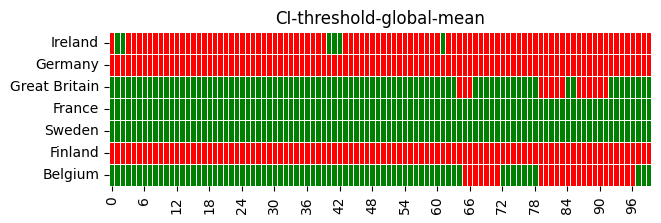

In [14]:
key_word = 'CI-threshold-global-mean'

list_CI_means=[]
for country in countries:
    CI_mean=get_CI_values(_dfs, country, start_date, end_date).mean()
    list_CI_means.append(CI_mean)
print(list_CI_means)
global_threshold = sum(list_CI_means)/len(list_CI_means)

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    availability_seq = create_availability_seq(CI_values, 'global_threshold', global_threshold)
    availability_matrix.loc[country, :] = availability_seq

plot_availability_heatmap("", availability_matrix, key_word, folder=folder)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

## Random availability matrix

### Without contraints

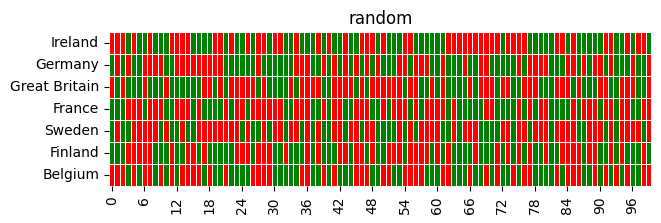

In [15]:
availability_matrix  = pd.DataFrame(np.random.randint(0,2,size=(len(countries), len(formatted_array))), index = countries, columns = formatted_array)

save_availability_matrix(datetime_values, formatted_array, 'random', availability_matrix)

plot_availability_heatmap("Random availability", availability_matrix, 'random', folder=folder)

### With constraints

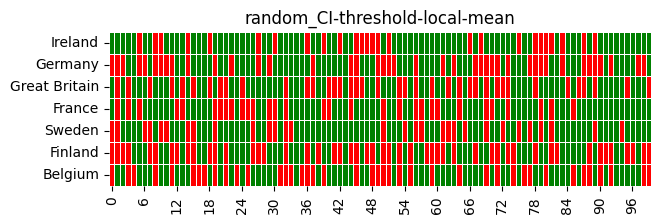

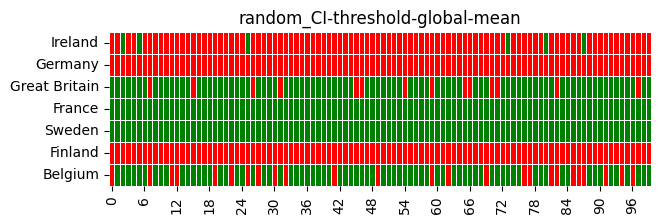

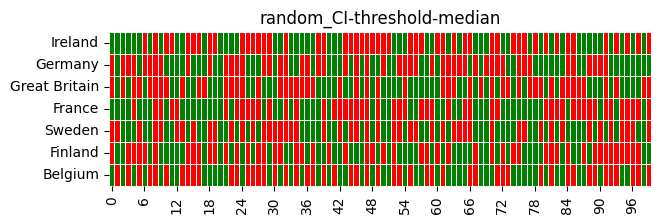

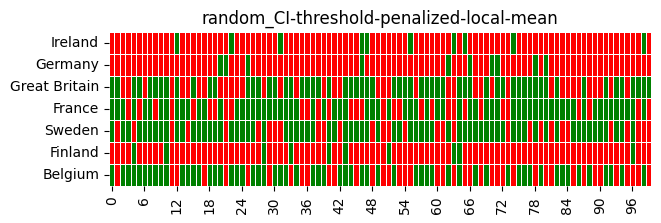

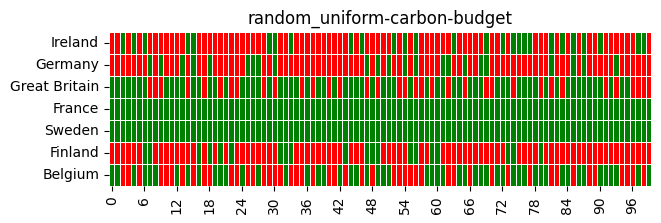

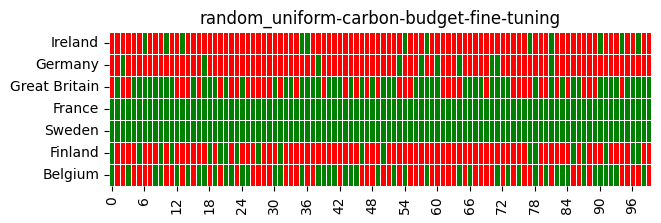

In [16]:
def create_matrix_with_zeros(num_rows, num_cols, num_zeros_per_row):
    # Create a matrix filled with ones
    matrix = np.ones((num_rows, num_cols), dtype=int)

    # Randomly set zeros in each row
    for i in range(num_rows):
        # Validate input
        if num_zeros_per_row[i] < 0 or num_zeros_per_row[i] > num_cols:
            raise ValueError("Invalid number of zeros per row.")
        indices = np.random.choice(num_cols, num_zeros_per_row[i], replace=False)
        matrix[i, indices] = 0

    return matrix

key_words_list = ['CI-threshold-local-mean', 'CI-threshold-global-mean', 'CI-threshold-median', 'CI-threshold-penalized-local-mean', 'uniform-carbon-budget', 'uniform-carbon-budget-fine-tuning']

for key_word in key_words_list:

    df = pd.DataFrame(pd.read_csv("availability_matrices/av-mat-1/availability_matrix_"+key_word+".csv", index_col=[0]))

    num_zeros_per_row = df.apply(lambda row: (row == 0).sum(), axis=1).values

    values = create_matrix_with_zeros(len(countries), len(formatted_array), num_zeros_per_row)

    availability_matrix  = pd.DataFrame(values, index = countries, columns = formatted_array)

    save_availability_matrix(datetime_values, formatted_array, 'random_for_'+key_word, availability_matrix)

    plot_availability_heatmap("", availability_matrix, 'random_'+key_word, folder=folder)

In [17]:
random_key_words_list = ['random_for_'+e for e in key_words_list]

print((' ').join(key_words_list) + ' ' + (' ').join(random_key_words_list))

CI-threshold-local-mean CI-threshold-global-mean CI-threshold-median CI-threshold-penalized-local-mean uniform-carbon-budget uniform-carbon-budget-fine-tuning random_for_CI-threshold-local-mean random_for_CI-threshold-global-mean random_for_CI-threshold-median random_for_CI-threshold-penalized-local-mean random_for_uniform-carbon-budget random_for_uniform-carbon-budget-fine-tuning


## Cyclic availability matrix

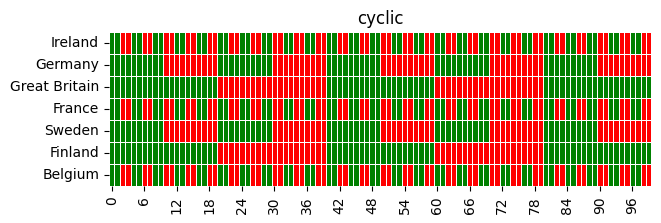

In [18]:
N=100
k_clients = [2, 10, 20, 2, 10, 20, 2]

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country, k in zip(countries, k_clients):
    block = np.array([1]*k+[0]*k)
    N_repeat = N // len(block)
    N_rest = N - N_repeat*len(block)
    availability_seq = np.tile(block, N_repeat)
    availability_seq = np.append(availability_seq, block[:N_rest])
    availability_matrix.loc[country, :] = availability_seq

plot_availability_heatmap("", availability_matrix, 'cyclic', folder=folder)

save_availability_matrix(datetime_values, formatted_array, 'cyclic', availability_matrix)